<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : BHPD2
Run time             : Monday 01 March 2021, 18:41:33
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.68,11.92,10.96,0.07,0.55,6.29,69.46,3.79,9.65,407.92,18.56,355.93,12.73
std,9.17,24.39,6.87,0.26,0.12,0.72,27.28,2.13,8.82,171.08,2.14,94.36,7.27
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73
25%,0.08,0.00,5.13,0.00,0.45,5.88,47.25,2.09,4.00,277.00,17.40,376.12,6.92
50%,0.25,0.00,9.12,0.00,0.54,6.21,77.90,3.20,5.00,330.00,19.10,391.38,11.43
75%,3.76,16.25,18.10,0.00,0.63,6.66,93.47,5.08,24.00,666.00,20.20,396.23,17.11
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.40,-0.49,-1.53,-0.28,-1.46,-3.80,-2.44,-1.25,-0.98,-1.29,-2.79,-3.77,-1.51
25%,-0.39,-0.49,-0.85,-0.28,-0.88,-0.57,-0.81,-0.80,-0.64,-0.77,-0.54,0.21,-0.80
50%,-0.37,-0.49,-0.27,-0.28,-0.15,-0.11,0.31,-0.28,-0.53,-0.46,0.25,0.38,-0.18
75%,0.01,0.18,1.04,-0.28,0.65,0.51,0.88,0.61,1.63,1.51,0.76,0.43,0.60
max,9.31,3.61,2.44,3.55,2.72,3.46,1.12,3.91,1.63,1.77,1.61,0.43,3.47


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 35s - loss: 820.6553 - mae: 26.5753 - mse: 820.6553

29/36 [=======================>......] - ETA: 0s - loss: 536.9244 - mae: 21.1701 - mse: 536.9244 

36/36 [==============================] - 2s 25ms/step - loss: 527.1821 - mae: 20.9309 - mse: 527.1821 - val_loss: 366.4511 - val_mae: 16.9141 - val_mse: 366.4511


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 315.7886 - mae: 15.7783 - mse: 315.7886

29/36 [=======================>......] - ETA: 0s - loss: 323.9455 - mae: 15.8696 - mse: 323.9455

36/36 [==============================] - 0s 4ms/step - loss: 309.9913 - mae: 15.4079 - mse: 309.9913 - val_loss: 148.6833 - val_mae: 9.7529 - val_mse: 148.6833


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 59.3099 - mae: 6.3410 - mse: 59.3099

33/36 [==========================>...] - ETA: 0s - loss: 103.5178 - mae: 8.1731 - mse: 103.5178

36/36 [==============================] - 0s 4ms/step - loss: 102.1436 - mae: 8.0940 - mse: 102.1436 - val_loss: 62.3322 - val_mae: 5.7757 - val_mse: 62.3322


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 39.9416 - mae: 5.4185 - mse: 39.9416

34/36 [===========================>..] - ETA: 0s - loss: 49.6750 - mae: 5.0914 - mse: 49.6750

36/36 [==============================] - 0s 4ms/step - loss: 49.3320 - mae: 5.0692 - mse: 49.3320 - val_loss: 38.5014 - val_mae: 4.6232 - val_mse: 38.5014


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 17.5183 - mae: 3.3742 - mse: 17.5183

34/36 [===========================>..] - ETA: 0s - loss: 35.7436 - mae: 4.2565 - mse: 35.7436

36/36 [==============================] - 0s 4ms/step - loss: 35.3356 - mae: 4.2235 - mse: 35.3356 - val_loss: 28.1337 - val_mae: 3.8852 - val_mse: 28.1337


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 22.1115 - mae: 3.4379 - mse: 22.1115

34/36 [===========================>..] - ETA: 0s - loss: 21.7539 - mae: 3.2625 - mse: 21.7539

36/36 [==============================] - 0s 4ms/step - loss: 21.9365 - mae: 3.2677 - mse: 21.9365 - val_loss: 21.7231 - val_mae: 3.5152 - val_mse: 21.7231


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 4.7899 - mae: 1.9316 - mse: 4.7899

34/36 [===========================>..] - ETA: 0s - loss: 23.6831 - mae: 3.1045 - mse: 23.6831

36/36 [==============================] - 0s 4ms/step - loss: 23.4475 - mae: 3.1046 - mse: 23.4475 - val_loss: 20.5046 - val_mae: 3.1931 - val_mse: 20.5046


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 5.8030 - mae: 1.7633 - mse: 5.8030

34/36 [===========================>..] - ETA: 0s - loss: 15.3522 - mae: 2.6887 - mse: 15.3522

36/36 [==============================] - 0s 4ms/step - loss: 15.6525 - mae: 2.7052 - mse: 15.6525 - val_loss: 17.8349 - val_mae: 3.1130 - val_mse: 17.8349


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 10.4013 - mae: 2.6733 - mse: 10.4013

34/36 [===========================>..] - ETA: 0s - loss: 15.8170 - mae: 2.6635 - mse: 15.8170

36/36 [==============================] - 0s 4ms/step - loss: 15.9569 - mae: 2.6720 - mse: 15.9569 - val_loss: 16.5775 - val_mae: 2.9695 - val_mse: 16.5775


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 91.7153 - mae: 5.3759 - mse: 91.7153

34/36 [===========================>..] - ETA: 0s - loss: 23.8195 - mae: 2.9376 - mse: 23.8195

36/36 [==============================] - 0s 4ms/step - loss: 23.2261 - mae: 2.9186 - mse: 23.2261 - val_loss: 16.0855 - val_mae: 3.1254 - val_mse: 16.0855


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 8.8565 - mae: 2.2688 - mse: 8.8565

34/36 [===========================>..] - ETA: 0s - loss: 17.4861 - mae: 2.5884 - mse: 17.4861

36/36 [==============================] - 0s 4ms/step - loss: 17.3960 - mae: 2.5932 - mse: 17.3960 - val_loss: 14.6855 - val_mae: 2.7753 - val_mse: 14.6855


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 9.9510 - mae: 2.6078 - mse: 9.9510

34/36 [===========================>..] - ETA: 0s - loss: 13.1098 - mae: 2.4412 - mse: 13.1098

36/36 [==============================] - 0s 4ms/step - loss: 13.2974 - mae: 2.4527 - mse: 13.2974 - val_loss: 14.2963 - val_mae: 2.7852 - val_mse: 14.2963


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 4.7602 - mae: 1.8258 - mse: 4.7602

34/36 [===========================>..] - ETA: 0s - loss: 16.5663 - mae: 2.4904 - mse: 16.5663

36/36 [==============================] - 0s 4ms/step - loss: 16.4325 - mae: 2.4938 - mse: 16.4325 - val_loss: 13.7564 - val_mae: 2.8934 - val_mse: 13.7564


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 13.3699 - mae: 3.1891 - mse: 13.3699

34/36 [===========================>..] - ETA: 0s - loss: 12.3543 - mae: 2.5245 - mse: 12.3543

36/36 [==============================] - 0s 4ms/step - loss: 12.5363 - mae: 2.5235 - mse: 12.5363 - val_loss: 12.9430 - val_mae: 2.6516 - val_mse: 12.9430


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 68.4972 - mae: 4.1083 - mse: 68.4972

34/36 [===========================>..] - ETA: 0s - loss: 20.2423 - mae: 2.7711 - mse: 20.2423

36/36 [==============================] - 0s 4ms/step - loss: 19.7471 - mae: 2.7515 - mse: 19.7471 - val_loss: 13.4048 - val_mae: 2.6880 - val_mse: 13.4048


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 4.3792 - mae: 1.8021 - mse: 4.3792

34/36 [===========================>..] - ETA: 0s - loss: 16.5802 - mae: 2.4869 - mse: 16.5802

36/36 [==============================] - 0s 4ms/step - loss: 16.3510 - mae: 2.4826 - mse: 16.3510 - val_loss: 12.8310 - val_mae: 2.6340 - val_mse: 12.8310


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 16.0477 - mae: 3.5006 - mse: 16.0477

34/36 [===========================>..] - ETA: 0s - loss: 10.6636 - mae: 2.2813 - mse: 10.6636

36/36 [==============================] - 0s 4ms/step - loss: 10.8826 - mae: 2.2884 - mse: 10.8826 - val_loss: 12.0806 - val_mae: 2.6247 - val_mse: 12.0806


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 8.6191 - mae: 2.3694 - mse: 8.6191

34/36 [===========================>..] - ETA: 0s - loss: 11.6103 - mae: 2.2973 - mse: 11.6103

36/36 [==============================] - 0s 4ms/step - loss: 11.7191 - mae: 2.3040 - mse: 11.7191 - val_loss: 11.9184 - val_mae: 2.6959 - val_mse: 11.9184


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 14.6948 - mae: 3.1449 - mse: 14.6948

34/36 [===========================>..] - ETA: 0s - loss: 11.3195 - mae: 2.4608 - mse: 11.3195

36/36 [==============================] - 0s 4ms/step - loss: 11.4301 - mae: 2.4512 - mse: 11.4301 - val_loss: 11.3863 - val_mae: 2.5772 - val_mse: 11.3863


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 9.3119 - mae: 2.2334 - mse: 9.3119

34/36 [===========================>..] - ETA: 0s - loss: 9.4933 - mae: 2.2492 - mse: 9.4933

36/36 [==============================] - 0s 4ms/step - loss: 9.7270 - mae: 2.2546 - mse: 9.7270 - val_loss: 11.9726 - val_mae: 2.5209 - val_mse: 11.9726


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 10.2041 - mae: 2.4026 - mse: 10.2041

34/36 [===========================>..] - ETA: 0s - loss: 11.7656 - mae: 2.2168 - mse: 11.7656

36/36 [==============================] - 0s 4ms/step - loss: 11.7891 - mae: 2.2266 - mse: 11.7891 - val_loss: 11.6104 - val_mae: 2.5028 - val_mse: 11.6104


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 4.3200 - mae: 1.6309 - mse: 4.3200

34/36 [===========================>..] - ETA: 0s - loss: 10.0424 - mae: 2.1249 - mse: 10.0424

36/36 [==============================] - 0s 4ms/step - loss: 10.1912 - mae: 2.1403 - mse: 10.1912 - val_loss: 11.0094 - val_mae: 2.5126 - val_mse: 11.0094


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 11.7311 - mae: 2.7516 - mse: 11.7311

34/36 [===========================>..] - ETA: 0s - loss: 14.9133 - mae: 2.4718 - mse: 14.9133

36/36 [==============================] - 0s 4ms/step - loss: 14.6403 - mae: 2.4542 - mse: 14.6403 - val_loss: 10.7057 - val_mae: 2.4868 - val_mse: 10.7057


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 21.5207 - mae: 3.0129 - mse: 21.5207

34/36 [===========================>..] - ETA: 0s - loss: 11.4855 - mae: 2.2650 - mse: 11.4855

36/36 [==============================] - 0s 4ms/step - loss: 11.4889 - mae: 2.2633 - mse: 11.4889 - val_loss: 12.7086 - val_mae: 2.6150 - val_mse: 12.7086


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 4.3034 - mae: 1.7330 - mse: 4.3034

34/36 [===========================>..] - ETA: 0s - loss: 9.3907 - mae: 2.1392 - mse: 9.3907

36/36 [==============================] - 0s 4ms/step - loss: 9.5448 - mae: 2.1476 - mse: 9.5448 - val_loss: 10.6592 - val_mae: 2.4392 - val_mse: 10.6592


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 3.7952 - mae: 1.5505 - mse: 3.7952

34/36 [===========================>..] - ETA: 0s - loss: 8.5280 - mae: 2.1006 - mse: 8.5280

36/36 [==============================] - 0s 4ms/step - loss: 8.7323 - mae: 2.1100 - mse: 8.7323 - val_loss: 10.3444 - val_mae: 2.4491 - val_mse: 10.3444


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 2.1216 - mae: 1.2292 - mse: 2.1216

34/36 [===========================>..] - ETA: 0s - loss: 9.9900 - mae: 2.1214 - mse: 9.9900

36/36 [==============================] - 0s 4ms/step - loss: 10.0589 - mae: 2.1262 - mse: 10.0589 - val_loss: 10.9042 - val_mae: 2.4283 - val_mse: 10.9042


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 3.3230 - mae: 1.3775 - mse: 3.3230

34/36 [===========================>..] - ETA: 0s - loss: 11.4200 - mae: 2.3133 - mse: 11.4200

36/36 [==============================] - 0s 4ms/step - loss: 11.3581 - mae: 2.3027 - mse: 11.3581 - val_loss: 10.4503 - val_mae: 2.4054 - val_mse: 10.4503


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 33.9899 - mae: 3.5797 - mse: 33.9899

34/36 [===========================>..] - ETA: 0s - loss: 14.3554 - mae: 2.3502 - mse: 14.3554

36/36 [==============================] - 0s 4ms/step - loss: 14.0357 - mae: 2.3363 - mse: 14.0357 - val_loss: 10.9305 - val_mae: 2.5384 - val_mse: 10.9305


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 6.6930 - mae: 2.0682 - mse: 6.6930

34/36 [===========================>..] - ETA: 0s - loss: 9.3449 - mae: 2.1414 - mse: 9.3449

36/36 [==============================] - 0s 4ms/step - loss: 9.4282 - mae: 2.1445 - mse: 9.4282 - val_loss: 10.2903 - val_mae: 2.4415 - val_mse: 10.2903


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 11.8937 - mae: 2.3838 - mse: 11.8937

34/36 [===========================>..] - ETA: 0s - loss: 10.5827 - mae: 2.2641 - mse: 10.5827

36/36 [==============================] - 0s 4ms/step - loss: 10.5401 - mae: 2.2549 - mse: 10.5401 - val_loss: 10.1078 - val_mae: 2.4803 - val_mse: 10.1078


Epoch 32/100
 1/36 [..............................] - ETA: 0s - loss: 6.2220 - mae: 1.6252 - mse: 6.2220

34/36 [===========================>..] - ETA: 0s - loss: 7.1669 - mae: 1.9461 - mse: 7.1669

36/36 [==============================] - 0s 4ms/step - loss: 7.3891 - mae: 1.9584 - mse: 7.3891 - val_loss: 10.8149 - val_mae: 2.4682 - val_mse: 10.8149


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 7.1659 - mae: 1.8492 - mse: 7.1659

34/36 [===========================>..] - ETA: 0s - loss: 10.5973 - mae: 2.1637 - mse: 10.5973

36/36 [==============================] - 0s 4ms/step - loss: 10.5331 - mae: 2.1599 - mse: 10.5331 - val_loss: 10.4850 - val_mae: 2.3976 - val_mse: 10.4850


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 4.9443 - mae: 1.6369 - mse: 4.9443

34/36 [===========================>..] - ETA: 0s - loss: 9.7709 - mae: 2.0532 - mse: 9.7709

36/36 [==============================] - 0s 4ms/step - loss: 9.7843 - mae: 2.0587 - mse: 9.7843 - val_loss: 10.2603 - val_mae: 2.3652 - val_mse: 10.2603


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 3.8693 - mae: 1.7068 - mse: 3.8693

34/36 [===========================>..] - ETA: 0s - loss: 7.9969 - mae: 1.9389 - mse: 7.9969

36/36 [==============================] - 0s 4ms/step - loss: 8.1164 - mae: 1.9520 - mse: 8.1164 - val_loss: 10.2702 - val_mae: 2.3564 - val_mse: 10.2702


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 5.1246 - mae: 1.7626 - mse: 5.1246

34/36 [===========================>..] - ETA: 0s - loss: 10.1620 - mae: 2.1557 - mse: 10.1620

36/36 [==============================] - 0s 4ms/step - loss: 10.1048 - mae: 2.1496 - mse: 10.1048 - val_loss: 10.9475 - val_mae: 2.4407 - val_mse: 10.9475


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 26.8062 - mae: 3.5022 - mse: 26.8062

34/36 [===========================>..] - ETA: 0s - loss: 9.9746 - mae: 2.1454 - mse: 9.9746  

36/36 [==============================] - 0s 4ms/step - loss: 9.9147 - mae: 2.1392 - mse: 9.9147 - val_loss: 9.3594 - val_mae: 2.3350 - val_mse: 9.3594


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 31.4384 - mae: 3.7348 - mse: 31.4384

34/36 [===========================>..] - ETA: 0s - loss: 11.1125 - mae: 2.2808 - mse: 11.1125

36/36 [==============================] - 0s 4ms/step - loss: 10.9497 - mae: 2.2646 - mse: 10.9497 - val_loss: 9.8773 - val_mae: 2.3356 - val_mse: 9.8773


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 3.0597 - mae: 1.4835 - mse: 3.0597

34/36 [===========================>..] - ETA: 0s - loss: 7.6970 - mae: 1.8359 - mse: 7.6970

36/36 [==============================] - 0s 4ms/step - loss: 7.8042 - mae: 1.8512 - mse: 7.8042 - val_loss: 9.5791 - val_mae: 2.3411 - val_mse: 9.5791


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 10.4556 - mae: 2.2817 - mse: 10.4556

34/36 [===========================>..] - ETA: 0s - loss: 8.9211 - mae: 2.0942 - mse: 8.9211  

36/36 [==============================] - 0s 4ms/step - loss: 8.9099 - mae: 2.0918 - mse: 8.9099 - val_loss: 9.5765 - val_mae: 2.3260 - val_mse: 9.5765


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 5.0242 - mae: 1.6484 - mse: 5.0242

34/36 [===========================>..] - ETA: 0s - loss: 6.9539 - mae: 1.9069 - mse: 6.9539

36/36 [==============================] - 0s 4ms/step - loss: 7.0982 - mae: 1.9182 - mse: 7.0982 - val_loss: 10.1250 - val_mae: 2.4027 - val_mse: 10.1250


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 5.9777 - mae: 1.6900 - mse: 5.9777

34/36 [===========================>..] - ETA: 0s - loss: 9.1127 - mae: 2.0323 - mse: 9.1127

36/36 [==============================] - 0s 4ms/step - loss: 9.0609 - mae: 2.0304 - mse: 9.0609 - val_loss: 9.2410 - val_mae: 2.3204 - val_mse: 9.2410


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 3.8947 - mae: 1.6572 - mse: 3.8947

34/36 [===========================>..] - ETA: 0s - loss: 6.8456 - mae: 1.8275 - mse: 6.8456

36/36 [==============================] - 0s 4ms/step - loss: 6.9718 - mae: 1.8414 - mse: 6.9718 - val_loss: 10.1315 - val_mae: 2.3870 - val_mse: 10.1315


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 2.1908 - mae: 1.0202 - mse: 2.1908

34/36 [===========================>..] - ETA: 0s - loss: 8.4003 - mae: 1.9864 - mse: 8.4003

36/36 [==============================] - 0s 4ms/step - loss: 8.3959 - mae: 1.9868 - mse: 8.3959 - val_loss: 9.5313 - val_mae: 2.3538 - val_mse: 9.5313


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 2.9424 - mae: 1.4150 - mse: 2.9424

34/36 [===========================>..] - ETA: 0s - loss: 7.4175 - mae: 1.8604 - mse: 7.4175

36/36 [==============================] - 0s 4ms/step - loss: 7.4903 - mae: 1.8714 - mse: 7.4903 - val_loss: 9.4255 - val_mae: 2.3224 - val_mse: 9.4255


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 3.2843 - mae: 1.5118 - mse: 3.2843

33/36 [==========================>...] - ETA: 0s - loss: 5.4673 - mae: 1.7281 - mse: 5.4673

36/36 [==============================] - 0s 4ms/step - loss: 5.7588 - mae: 1.7538 - mse: 5.7588 - val_loss: 9.4536 - val_mae: 2.2841 - val_mse: 9.4536


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 4.5242 - mae: 1.8014 - mse: 4.5242

34/36 [===========================>..] - ETA: 0s - loss: 8.0858 - mae: 1.9638 - mse: 8.0858

36/36 [==============================] - 0s 4ms/step - loss: 8.0666 - mae: 1.9616 - mse: 8.0666 - val_loss: 9.3771 - val_mae: 2.2794 - val_mse: 9.3771


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 2.5158 - mae: 1.3427 - mse: 2.5158

34/36 [===========================>..] - ETA: 0s - loss: 5.2510 - mae: 1.7276 - mse: 5.2510

36/36 [==============================] - 0s 4ms/step - loss: 5.4544 - mae: 1.7439 - mse: 5.4544 - val_loss: 9.0303 - val_mae: 2.2857 - val_mse: 9.0303


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 7.0113 - mae: 2.3244 - mse: 7.0113

34/36 [===========================>..] - ETA: 0s - loss: 10.0570 - mae: 2.0944 - mse: 10.0570

36/36 [==============================] - 0s 4ms/step - loss: 9.8586 - mae: 2.0777 - mse: 9.8586 - val_loss: 9.6222 - val_mae: 2.3390 - val_mse: 9.6222


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 8.6105 - mae: 2.3070 - mse: 8.6105

34/36 [===========================>..] - ETA: 0s - loss: 6.2373 - mae: 1.8485 - mse: 6.2373

36/36 [==============================] - 0s 4ms/step - loss: 6.3645 - mae: 1.8534 - mse: 6.3645 - val_loss: 9.4830 - val_mae: 2.3877 - val_mse: 9.4830


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 6.5701 - mae: 2.1784 - mse: 6.5701

34/36 [===========================>..] - ETA: 0s - loss: 9.8791 - mae: 2.0646 - mse: 9.8791

36/36 [==============================] - 0s 4ms/step - loss: 9.6962 - mae: 2.0534 - mse: 9.6962 - val_loss: 9.5123 - val_mae: 2.3311 - val_mse: 9.5123


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 6.9199 - mae: 2.1750 - mse: 6.9199

34/36 [===========================>..] - ETA: 0s - loss: 7.2686 - mae: 1.9192 - mse: 7.2686

36/36 [==============================] - 0s 4ms/step - loss: 7.2934 - mae: 1.9189 - mse: 7.2934 - val_loss: 9.7919 - val_mae: 2.3407 - val_mse: 9.7919


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 5.5711 - mae: 1.9560 - mse: 5.5711

34/36 [===========================>..] - ETA: 0s - loss: 7.4455 - mae: 1.8877 - mse: 7.4455

36/36 [==============================] - 0s 4ms/step - loss: 7.4496 - mae: 1.8885 - mse: 7.4496 - val_loss: 9.3431 - val_mae: 2.2829 - val_mse: 9.3431


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 5.0990 - mae: 1.7059 - mse: 5.0990

34/36 [===========================>..] - ETA: 0s - loss: 7.5390 - mae: 1.8675 - mse: 7.5390

36/36 [==============================] - 0s 4ms/step - loss: 7.5137 - mae: 1.8678 - mse: 7.5137 - val_loss: 9.8575 - val_mae: 2.3537 - val_mse: 9.8575


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 6.4456 - mae: 1.8713 - mse: 6.4456

34/36 [===========================>..] - ETA: 0s - loss: 7.2897 - mae: 1.8513 - mse: 7.2897

36/36 [==============================] - 0s 4ms/step - loss: 7.2544 - mae: 1.8538 - mse: 7.2544 - val_loss: 9.9189 - val_mae: 2.3745 - val_mse: 9.9189


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 3.0889 - mae: 1.4011 - mse: 3.0889

34/36 [===========================>..] - ETA: 0s - loss: 6.3596 - mae: 1.7326 - mse: 6.3596

36/36 [==============================] - 0s 4ms/step - loss: 6.4362 - mae: 1.7449 - mse: 6.4362 - val_loss: 9.2654 - val_mae: 2.3062 - val_mse: 9.2654


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 42.2115 - mae: 3.5370 - mse: 42.2115

34/36 [===========================>..] - ETA: 0s - loss: 10.0257 - mae: 2.0061 - mse: 10.0257

36/36 [==============================] - 0s 4ms/step - loss: 9.7742 - mae: 1.9938 - mse: 9.7742 - val_loss: 9.3887 - val_mae: 2.3165 - val_mse: 9.3887


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 1.2311 - mae: 0.9329 - mse: 1.2311

34/36 [===========================>..] - ETA: 0s - loss: 8.1524 - mae: 1.8889 - mse: 8.1524

36/36 [==============================] - 0s 4ms/step - loss: 8.0380 - mae: 1.8832 - mse: 8.0380 - val_loss: 9.1425 - val_mae: 2.2983 - val_mse: 9.1425


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 5.4501 - mae: 2.0312 - mse: 5.4501

34/36 [===========================>..] - ETA: 0s - loss: 6.9204 - mae: 1.7908 - mse: 6.9204

36/36 [==============================] - 0s 4ms/step - loss: 6.9039 - mae: 1.7940 - mse: 6.9039 - val_loss: 10.1422 - val_mae: 2.3810 - val_mse: 10.1422


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 4.0486 - mae: 1.4273 - mse: 4.0486

34/36 [===========================>..] - ETA: 0s - loss: 5.0735 - mae: 1.6587 - mse: 5.0735

36/36 [==============================] - 0s 4ms/step - loss: 5.2159 - mae: 1.6703 - mse: 5.2159 - val_loss: 9.2774 - val_mae: 2.3348 - val_mse: 9.2774


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 3.7692 - mae: 1.5098 - mse: 3.7692

34/36 [===========================>..] - ETA: 0s - loss: 4.5414 - mae: 1.5457 - mse: 4.5414

36/36 [==============================] - 0s 4ms/step - loss: 4.7032 - mae: 1.5662 - mse: 4.7032 - val_loss: 9.2544 - val_mae: 2.3472 - val_mse: 9.2544


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 14.1521 - mae: 2.5104 - mse: 14.1521

34/36 [===========================>..] - ETA: 0s - loss: 7.1558 - mae: 1.9008 - mse: 7.1558  

36/36 [==============================] - 0s 4ms/step - loss: 7.0993 - mae: 1.8902 - mse: 7.0993 - val_loss: 9.1819 - val_mae: 2.3220 - val_mse: 9.1819


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 2.4848 - mae: 1.3113 - mse: 2.4848

34/36 [===========================>..] - ETA: 0s - loss: 6.1309 - mae: 1.7177 - mse: 6.1309

36/36 [==============================] - 0s 4ms/step - loss: 6.1473 - mae: 1.7232 - mse: 6.1473 - val_loss: 9.7829 - val_mae: 2.3943 - val_mse: 9.7829


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 4.0655 - mae: 1.6831 - mse: 4.0655

34/36 [===========================>..] - ETA: 0s - loss: 5.0143 - mae: 1.7087 - mse: 5.0143

36/36 [==============================] - 0s 4ms/step - loss: 5.1355 - mae: 1.7173 - mse: 5.1355 - val_loss: 9.4744 - val_mae: 2.3056 - val_mse: 9.4744


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 4.1810 - mae: 1.5446 - mse: 4.1810

34/36 [===========================>..] - ETA: 0s - loss: 4.8101 - mae: 1.6590 - mse: 4.8101

36/36 [==============================] - 0s 4ms/step - loss: 4.9310 - mae: 1.6712 - mse: 4.9310 - val_loss: 9.2431 - val_mae: 2.2771 - val_mse: 9.2431


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 7.9442 - mae: 2.2875 - mse: 7.9442

34/36 [===========================>..] - ETA: 0s - loss: 7.2274 - mae: 1.9590 - mse: 7.2274

36/36 [==============================] - 0s 4ms/step - loss: 7.1330 - mae: 1.9434 - mse: 7.1330 - val_loss: 10.0637 - val_mae: 2.3787 - val_mse: 10.0637


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 3.0155 - mae: 1.4887 - mse: 3.0155

33/36 [==========================>...] - ETA: 0s - loss: 4.8413 - mae: 1.7057 - mse: 4.8413

36/36 [==============================] - 0s 4ms/step - loss: 4.9432 - mae: 1.7104 - mse: 4.9432 - val_loss: 10.6425 - val_mae: 2.4232 - val_mse: 10.6425


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 5.2355 - mae: 1.8739 - mse: 5.2355

33/36 [==========================>...] - ETA: 0s - loss: 7.1915 - mae: 1.8727 - mse: 7.1915

36/36 [==============================] - 0s 4ms/step - loss: 7.0821 - mae: 1.8639 - mse: 7.0821 - val_loss: 9.9486 - val_mae: 2.3677 - val_mse: 9.9486


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 2.8912 - mae: 1.2661 - mse: 2.8912

34/36 [===========================>..] - ETA: 0s - loss: 5.9240 - mae: 1.6713 - mse: 5.9240

36/36 [==============================] - 0s 4ms/step - loss: 5.9329 - mae: 1.6759 - mse: 5.9329 - val_loss: 9.5338 - val_mae: 2.3042 - val_mse: 9.5338


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 4.3385 - mae: 1.5660 - mse: 4.3385

33/36 [==========================>...] - ETA: 0s - loss: 4.4338 - mae: 1.6182 - mse: 4.4338

36/36 [==============================] - 0s 4ms/step - loss: 4.5776 - mae: 1.6304 - mse: 4.5776 - val_loss: 9.2585 - val_mae: 2.2633 - val_mse: 9.2585


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 4.5695 - mae: 1.8160 - mse: 4.5695

34/36 [===========================>..] - ETA: 0s - loss: 5.8897 - mae: 1.7104 - mse: 5.8897

36/36 [==============================] - 0s 4ms/step - loss: 5.8780 - mae: 1.7089 - mse: 5.8780 - val_loss: 9.4555 - val_mae: 2.3616 - val_mse: 9.4555


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 2.9233 - mae: 1.3537 - mse: 2.9233

33/36 [==========================>...] - ETA: 0s - loss: 6.4952 - mae: 1.7174 - mse: 6.4952

36/36 [==============================] - 0s 4ms/step - loss: 6.3992 - mae: 1.7181 - mse: 6.3992 - val_loss: 9.6444 - val_mae: 2.3257 - val_mse: 9.6444


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 2.6198 - mae: 1.4640 - mse: 2.6198

29/36 [=======================>......] - ETA: 0s - loss: 5.5768 - mae: 1.6959 - mse: 5.5768

36/36 [==============================] - 0s 4ms/step - loss: 5.5339 - mae: 1.6942 - mse: 5.5339 - val_loss: 10.5231 - val_mae: 2.5063 - val_mse: 10.5231


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 4.4950 - mae: 1.4474 - mse: 4.4950

29/36 [=======================>......] - ETA: 0s - loss: 5.6547 - mae: 1.7134 - mse: 5.6547

36/36 [==============================] - 0s 4ms/step - loss: 5.6532 - mae: 1.7132 - mse: 5.6532 - val_loss: 9.0941 - val_mae: 2.2430 - val_mse: 9.0941


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 4.2808 - mae: 1.7725 - mse: 4.2808

29/36 [=======================>......] - ETA: 0s - loss: 6.1228 - mae: 1.8543 - mse: 6.1228

36/36 [==============================] - 0s 4ms/step - loss: 6.0196 - mae: 1.8187 - mse: 6.0196 - val_loss: 10.0033 - val_mae: 2.3537 - val_mse: 10.0033


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 2.4221 - mae: 1.1343 - mse: 2.4221

30/36 [========================>.....] - ETA: 0s - loss: 4.1946 - mae: 1.5413 - mse: 4.1946

36/36 [==============================] - 0s 4ms/step - loss: 4.4301 - mae: 1.5707 - mse: 4.4301 - val_loss: 9.1314 - val_mae: 2.2875 - val_mse: 9.1314


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 5.0121 - mae: 1.7153 - mse: 5.0121

30/36 [========================>.....] - ETA: 0s - loss: 5.0351 - mae: 1.6183 - mse: 5.0351

36/36 [==============================] - 0s 4ms/step - loss: 5.0792 - mae: 1.6261 - mse: 5.0792 - val_loss: 9.6146 - val_mae: 2.3574 - val_mse: 9.6146


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 2.5820 - mae: 1.3799 - mse: 2.5820

29/36 [=======================>......] - ETA: 0s - loss: 5.2953 - mae: 1.6405 - mse: 5.2953

36/36 [==============================] - 0s 4ms/step - loss: 5.3188 - mae: 1.6513 - mse: 5.3188 - val_loss: 9.4899 - val_mae: 2.3598 - val_mse: 9.4899


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 6.3683 - mae: 1.8826 - mse: 6.3683

30/36 [========================>.....] - ETA: 0s - loss: 4.0044 - mae: 1.5464 - mse: 4.0044

36/36 [==============================] - 0s 4ms/step - loss: 4.1686 - mae: 1.5630 - mse: 4.1686 - val_loss: 9.3313 - val_mae: 2.2644 - val_mse: 9.3313


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 11.2149 - mae: 2.4181 - mse: 11.2149

32/36 [=========================>....] - ETA: 0s - loss: 5.1197 - mae: 1.7075 - mse: 5.1197  

36/36 [==============================] - 0s 4ms/step - loss: 5.0788 - mae: 1.6972 - mse: 5.0788 - val_loss: 9.9378 - val_mae: 2.3022 - val_mse: 9.9378


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 1.4385 - mae: 0.8965 - mse: 1.4385

33/36 [==========================>...] - ETA: 0s - loss: 4.0133 - mae: 1.4800 - mse: 4.0133

36/36 [==============================] - 0s 4ms/step - loss: 4.1273 - mae: 1.4965 - mse: 4.1273 - val_loss: 10.8592 - val_mae: 2.4694 - val_mse: 10.8592


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 5.0292 - mae: 1.9395 - mse: 5.0292

33/36 [==========================>...] - ETA: 0s - loss: 5.7289 - mae: 1.7079 - mse: 5.7289

36/36 [==============================] - 0s 4ms/step - loss: 5.6518 - mae: 1.6982 - mse: 5.6518 - val_loss: 10.0976 - val_mae: 2.3798 - val_mse: 10.0976


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 8.6699 - mae: 2.3824 - mse: 8.6699

33/36 [==========================>...] - ETA: 0s - loss: 5.5654 - mae: 1.7310 - mse: 5.5654

36/36 [==============================] - 0s 4ms/step - loss: 5.5151 - mae: 1.7205 - mse: 5.5151 - val_loss: 9.6754 - val_mae: 2.3623 - val_mse: 9.6754


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 4.5357 - mae: 1.7781 - mse: 4.5357

33/36 [==========================>...] - ETA: 0s - loss: 4.0814 - mae: 1.5638 - mse: 4.0814

36/36 [==============================] - 0s 4ms/step - loss: 4.1512 - mae: 1.5657 - mse: 4.1512 - val_loss: 11.0365 - val_mae: 2.4104 - val_mse: 11.0365


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 6.4269 - mae: 2.0289 - mse: 6.4269

33/36 [==========================>...] - ETA: 0s - loss: 4.9203 - mae: 1.6064 - mse: 4.9203

36/36 [==============================] - 0s 4ms/step - loss: 4.9118 - mae: 1.6053 - mse: 4.9118 - val_loss: 9.7858 - val_mae: 2.3077 - val_mse: 9.7858


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 2.1923 - mae: 1.2115 - mse: 2.1923

33/36 [==========================>...] - ETA: 0s - loss: 3.9008 - mae: 1.4805 - mse: 3.9008

36/36 [==============================] - 0s 4ms/step - loss: 3.9980 - mae: 1.4911 - mse: 3.9980 - val_loss: 10.0655 - val_mae: 2.3251 - val_mse: 10.0655


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 8.0132 - mae: 1.8202 - mse: 8.0132

33/36 [==========================>...] - ETA: 0s - loss: 4.6954 - mae: 1.5274 - mse: 4.6954

36/36 [==============================] - 0s 4ms/step - loss: 4.7092 - mae: 1.5292 - mse: 4.7092 - val_loss: 9.4244 - val_mae: 2.2671 - val_mse: 9.4244


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 5.1463 - mae: 1.7807 - mse: 5.1463

33/36 [==========================>...] - ETA: 0s - loss: 4.1792 - mae: 1.5463 - mse: 4.1792

36/36 [==============================] - 0s 4ms/step - loss: 4.2292 - mae: 1.5492 - mse: 4.2292 - val_loss: 9.7510 - val_mae: 2.3007 - val_mse: 9.7510


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 3.3645 - mae: 1.4511 - mse: 3.3645

33/36 [==========================>...] - ETA: 0s - loss: 4.7393 - mae: 1.5746 - mse: 4.7393

36/36 [==============================] - 0s 4ms/step - loss: 4.7310 - mae: 1.5752 - mse: 4.7310 - val_loss: 10.0711 - val_mae: 2.3494 - val_mse: 10.0711


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 1.7477 - mae: 0.9966 - mse: 1.7477

33/36 [==========================>...] - ETA: 0s - loss: 5.3938 - mae: 1.6194 - mse: 5.3938

36/36 [==============================] - 0s 4ms/step - loss: 5.3310 - mae: 1.6148 - mse: 5.3310 - val_loss: 9.3629 - val_mae: 2.2559 - val_mse: 9.3629


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 27.8543 - mae: 3.2737 - mse: 27.8543

33/36 [==========================>...] - ETA: 0s - loss: 6.1757 - mae: 1.5865 - mse: 6.1757  

36/36 [==============================] - 0s 4ms/step - loss: 5.9897 - mae: 1.5806 - mse: 5.9897 - val_loss: 9.8954 - val_mae: 2.3155 - val_mse: 9.8954


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 5.9039 - mae: 1.7434 - mse: 5.9039

33/36 [==========================>...] - ETA: 0s - loss: 3.5070 - mae: 1.4349 - mse: 3.5070

36/36 [==============================] - 0s 4ms/step - loss: 3.5993 - mae: 1.4465 - mse: 3.5993 - val_loss: 10.0380 - val_mae: 2.3217 - val_mse: 10.0380


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 8.2391 - mae: 2.0149 - mse: 8.2391

33/36 [==========================>...] - ETA: 0s - loss: 4.0579 - mae: 1.4960 - mse: 4.0579

36/36 [==============================] - 0s 4ms/step - loss: 4.1093 - mae: 1.5015 - mse: 4.1093 - val_loss: 10.2133 - val_mae: 2.3160 - val_mse: 10.2133


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 1.5280 - mae: 0.8573 - mse: 1.5280

33/36 [==========================>...] - ETA: 0s - loss: 4.0365 - mae: 1.4609 - mse: 4.0365

36/36 [==============================] - 0s 4ms/step - loss: 4.0767 - mae: 1.4691 - mse: 4.0767 - val_loss: 10.2056 - val_mae: 2.3780 - val_mse: 10.2056


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 4.5629 - mae: 1.5756 - mse: 4.5629

33/36 [==========================>...] - ETA: 0s - loss: 3.8873 - mae: 1.4877 - mse: 3.8873

36/36 [==============================] - 0s 4ms/step - loss: 3.9396 - mae: 1.4890 - mse: 3.9396 - val_loss: 9.6103 - val_mae: 2.2735 - val_mse: 9.6103


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 2.7845 - mae: 1.4086 - mse: 2.7845

33/36 [==========================>...] - ETA: 0s - loss: 3.5573 - mae: 1.4517 - mse: 3.5573

36/36 [==============================] - 0s 4ms/step - loss: 3.6334 - mae: 1.4583 - mse: 3.6334 - val_loss: 9.9200 - val_mae: 2.3324 - val_mse: 9.9200


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 3.6348 - mae: 1.3828 - mse: 3.6348

33/36 [==========================>...] - ETA: 0s - loss: 3.5600 - mae: 1.3744 - mse: 3.5600

36/36 [==============================] - 0s 4ms/step - loss: 3.6402 - mae: 1.3870 - mse: 3.6402 - val_loss: 9.7711 - val_mae: 2.2834 - val_mse: 9.7711


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 3.1237 - mae: 1.5199 - mse: 3.1237

33/36 [==========================>...] - ETA: 0s - loss: 4.4887 - mae: 1.5771 - mse: 4.4887

36/36 [==============================] - 0s 4ms/step - loss: 4.4480 - mae: 1.5691 - mse: 4.4480 - val_loss: 10.7803 - val_mae: 2.4217 - val_mse: 10.7803


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 3.0721 - mae: 1.4835 - mse: 3.0721

33/36 [==========================>...] - ETA: 0s - loss: 5.4807 - mae: 1.6019 - mse: 5.4807

36/36 [==============================] - 0s 4ms/step - loss: 5.3517 - mae: 1.5898 - mse: 5.3517 - val_loss: 9.5158 - val_mae: 2.2703 - val_mse: 9.5158


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 0.7394 - mae: 0.7038 - mse: 0.7394

33/36 [==========================>...] - ETA: 0s - loss: 3.4165 - mae: 1.3382 - mse: 3.4165

36/36 [==============================] - 0s 4ms/step - loss: 3.5067 - mae: 1.3559 - mse: 3.5067 - val_loss: 10.6235 - val_mae: 2.3723 - val_mse: 10.6235


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 10.6235
x_test / mae       : 2.3723
x_test / mse       : 10.6235


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2430


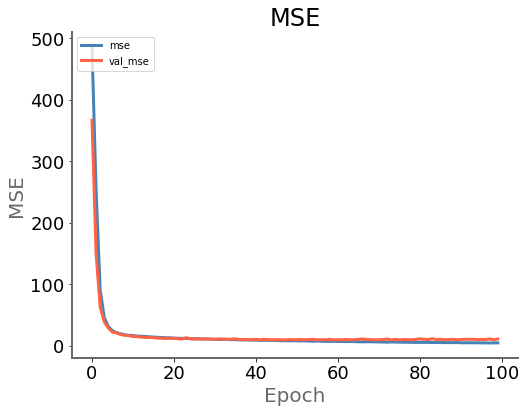

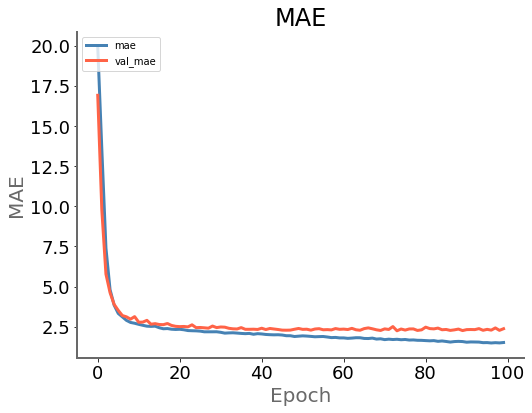

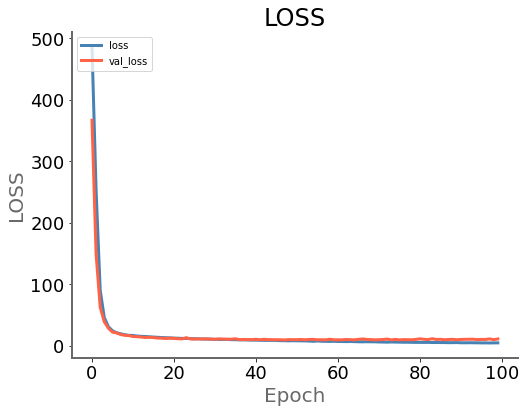

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 9.0303
x_test / mae       : 2.2857
x_test / mse       : 9.0303


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 11.37 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Monday 01 March 2021, 18:41:53
Duration is : 00:00:20 344ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>